# massive workflow

In [ ]:
from google import genai
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import csv
import time
from sentence_transformers import SentenceTransformer
import random
import re
from openai import OpenAI
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# FUNCTIONS

In [ ]:
def check_empty(text_list):
  empty_indices = []
  for i in range(0, len(text_list)):
    if re.fullmatch(r"[\s*]*", text_list[i]):
      empty_indices.append(i)

  return(empty_indices)

In [ ]:
# deals with the double pair of asterisks, pairing them up
def split_combine_doubleA(output, split_on):
  output_split = output.split(split_on)  # split on **

  sec_start = 1
  if output.startswith(split_on):
    sec_start = 0

  if sec_start == 1:
    sections = [output_split[i] + output_split[i+1] for i in range(sec_start, len(output_split)-1, 2)]
    sections.insert(0, output_split[0])
  else:
    # if it starts with **, then there is an empty string at the front
    output_split = output_split[1:]
    sections = [output_split[i] + output_split[i+1] for i in range(sec_start, len(output_split)-1, 2)]

  return sections

In [ ]:
# each segment is three sentences. the first of which is overlapping with previous segment.
def segment(output_sentences, comb_value, overlap_value):
  output_sentences_modified = []
  i = 0
  while(True):
    if i-overlap_value < 0:
      output_sentences_modified.append(" ".join(output_sentences[i:i+comb_value]) )
      i = i + comb_value
      continue
    if i+comb_value > len(output_sentences):
      output_sentences_modified.append(" ".join(output_sentences[i-overlap_value:]) )
      break
    output_sentences_modified.append(" ".join(output_sentences[i-overlap_value : i+comb_value]) )

    i = i + comb_value

  return(output_sentences_modified)

In [ ]:
# count tokens
client = genai.Client(api_key=GEMINI_API_KEY)
def count_tokens(output_sentences):
  tokens = []
  for i in output_sentences:
    weird_output = client.models.count_tokens(
        model="gemini-2.5-flash-lite", contents = i
    )

    tokens.append(weird_output.total_tokens)
  return(tokens)

In [ ]:
# returns intfload embeddings, L2 normalized
def get_embedding_intfloat(text, model="text-embedding-3-large"):
  model_intfloat = SentenceTransformer('intfloat/e5-base-v2')
  embeddings = model_intfloat.encode(text, normalize_embeddings=True)
  return(embeddings)

# WORK

# WORKFLOW FOR SENTENCE SPLIT

In [ ]:
output_files = sorted(glob.glob("cot1.*_output.txt"))
output_files

['cot1.0_output.txt',
 'cot1.1_output.txt',
 'cot1.2_output.txt',
 'cot1.3_output.txt',
 'cot1.4_output.txt',
 'cot1.5_output.txt',
 'cot1.6_output.txt',
 'cot1.7_output.txt',
 'cot1.8_output.txt',
 'cot1.9_output.txt']

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

embeddings_cot1_splitSentence_comb3_over0.csv
(240, 768)
[19, 29, 21, 29, 28, 21, 22, 24, 23, 24]
[[87, 86, 44, 102, 92, 90, 107, 61, 131, 100, 72, 154, 171, 110, 83, 80, 40, 87, 26], [124, 79, 34, 78, 41, 47, 85, 109, 138, 89, 98, 106, 122, 72, 65, 65, 102, 180, 197, 78, 54, 144, 55, 107, 106, 53, 73, 105, 1], [134, 101, 54, 140, 91, 124, 98, 148, 129, 106, 81, 140, 139, 100, 170, 130, 94, 45, 72, 69, 53], [146, 53, 59, 55, 95, 54, 88, 100, 132, 114, 84, 78, 75, 53, 127, 52, 60, 39, 63, 32, 39, 148, 116, 66, 54, 72, 52, 117, 33], [67, 94, 67, 125, 100, 49, 108, 63, 57, 88, 85, 77, 77, 89, 41, 50, 39, 88, 51, 56, 36, 58, 72, 105, 119, 58, 86, 61], [125, 77, 100, 80, 121, 108, 100, 64, 133, 124, 48, 206, 117, 152, 119, 58, 65, 32, 41, 95, 22], [113, 111, 76, 129, 74, 94, 74, 83, 40, 48, 98, 67, 87, 159, 209, 86, 84, 52, 57, 94, 99, 1], [90, 80, 45, 78, 119, 70, 100, 85, 179, 85, 118, 123, 70, 102, 62, 71, 95, 99, 117, 38, 43, 69, 68, 1], [89, 59, 80, 80, 118, 57, 115, 99, 43, 41, 59, 77

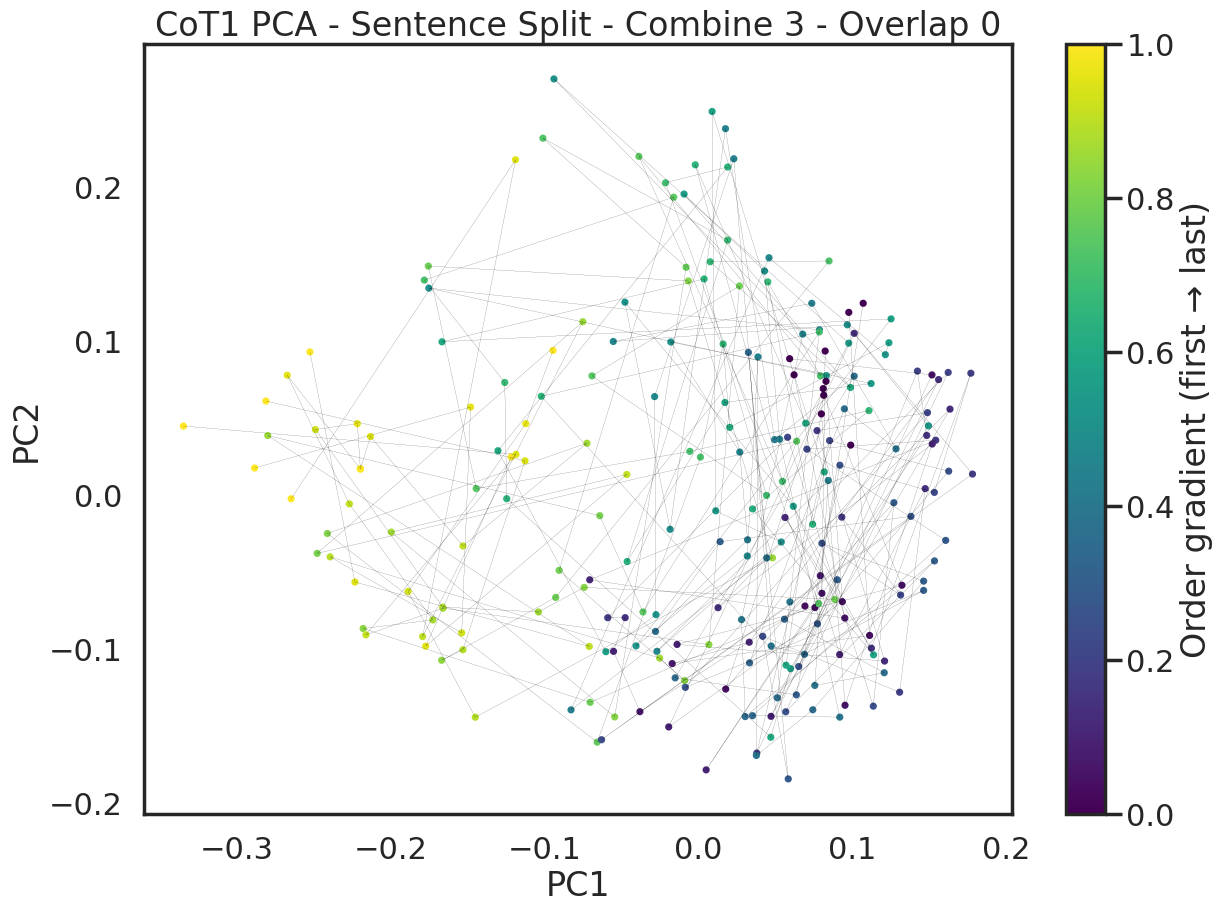

embeddings_cot1_splitSentence_comb3_over1.csv
(240, 768)
[19, 29, 21, 29, 28, 21, 22, 24, 23, 24]
[[87, 106, 86, 117, 125, 120, 128, 100, 138, 137, 97, 190, 260, 167, 102, 117, 53, 111, 52], [124, 108, 50, 92, 60, 57, 105, 157, 169, 119, 138, 144, 158, 100, 98, 78, 132, 225, 253, 109, 62, 157, 127, 139, 142, 64, 96, 144, 23], [134, 111, 94, 161, 121, 139, 142, 187, 203, 149, 114, 165, 236, 138, 181, 179, 110, 87, 100, 90, 98], [146, 78, 89, 68, 112, 76, 115, 159, 163, 156, 137, 118, 99, 80, 148, 78, 76, 55, 80, 50, 50, 157, 146, 106, 73, 83, 66, 128, 57], [67, 124, 119, 131, 135, 77, 120, 88, 95, 99, 147, 107, 115, 109, 64, 64, 56, 109, 86, 70, 55, 74, 86, 138, 147, 99, 105, 90], [125, 100, 139, 138, 135, 143, 150, 105, 160, 147, 69, 215, 173, 167, 205, 104, 77, 45, 45, 112, 48], [113, 123, 102, 146, 110, 106, 90, 96, 53, 59, 120, 104, 119, 188, 260, 209, 118, 91, 61, 123, 147, 29], [90, 105, 83, 94, 137, 104, 127, 122, 187, 163, 156, 159, 119, 133, 99, 93, 119, 156, 160, 51, 51, 79, 1

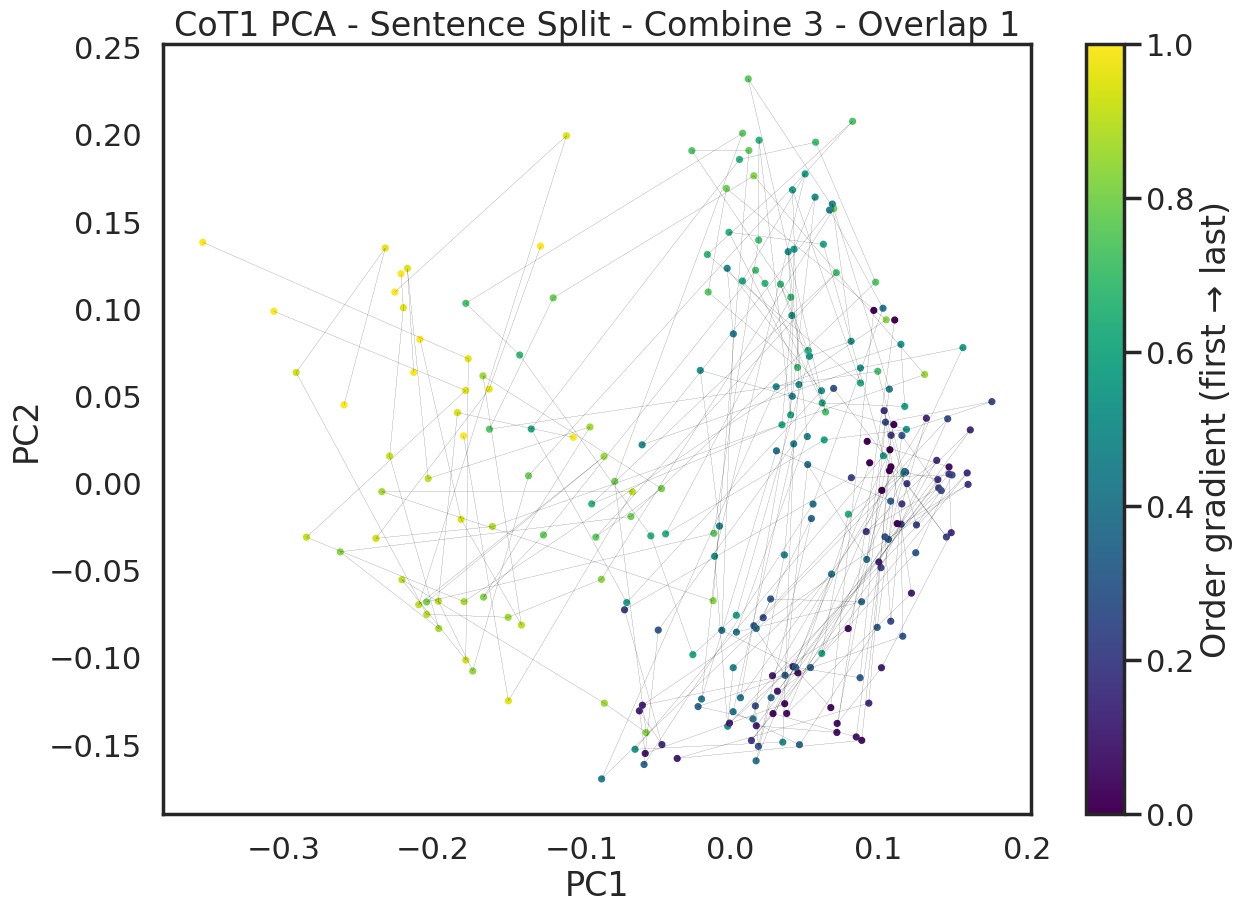

embeddings_cot1_splitSentence_comb5_over0.csv
(146, 768)
[12, 17, 13, 18, 17, 13, 13, 14, 14, 15]
[[129, 137, 144, 156, 182, 149, 134, 330, 121, 95, 136, 1], [187, 98, 71, 81, 198, 184, 167, 180, 115, 121, 364, 135, 124, 164, 175, 85, 144], [195, 169, 157, 181, 216, 206, 121, 281, 224, 180, 90, 136, 53], [167, 105, 134, 81, 200, 204, 136, 113, 165, 95, 65, 84, 156, 167, 98, 113, 160, 1], [108, 202, 139, 131, 119, 113, 122, 134, 111, 68, 132, 81, 80, 126, 183, 114, 90], [162, 172, 167, 165, 171, 191, 196, 224, 220, 109, 65, 116, 22], [198, 143, 160, 155, 104, 78, 132, 170, 317, 131, 115, 127, 99], [131, 92, 186, 132, 173, 212, 190, 174, 108, 106, 205, 106, 72, 106], [120, 116, 186, 120, 163, 71, 108, 159, 127, 119, 198, 95, 86, 97], [97, 130, 181, 172, 88, 173, 115, 103, 160, 129, 145, 176, 139, 101, 1]]
(146, 2)


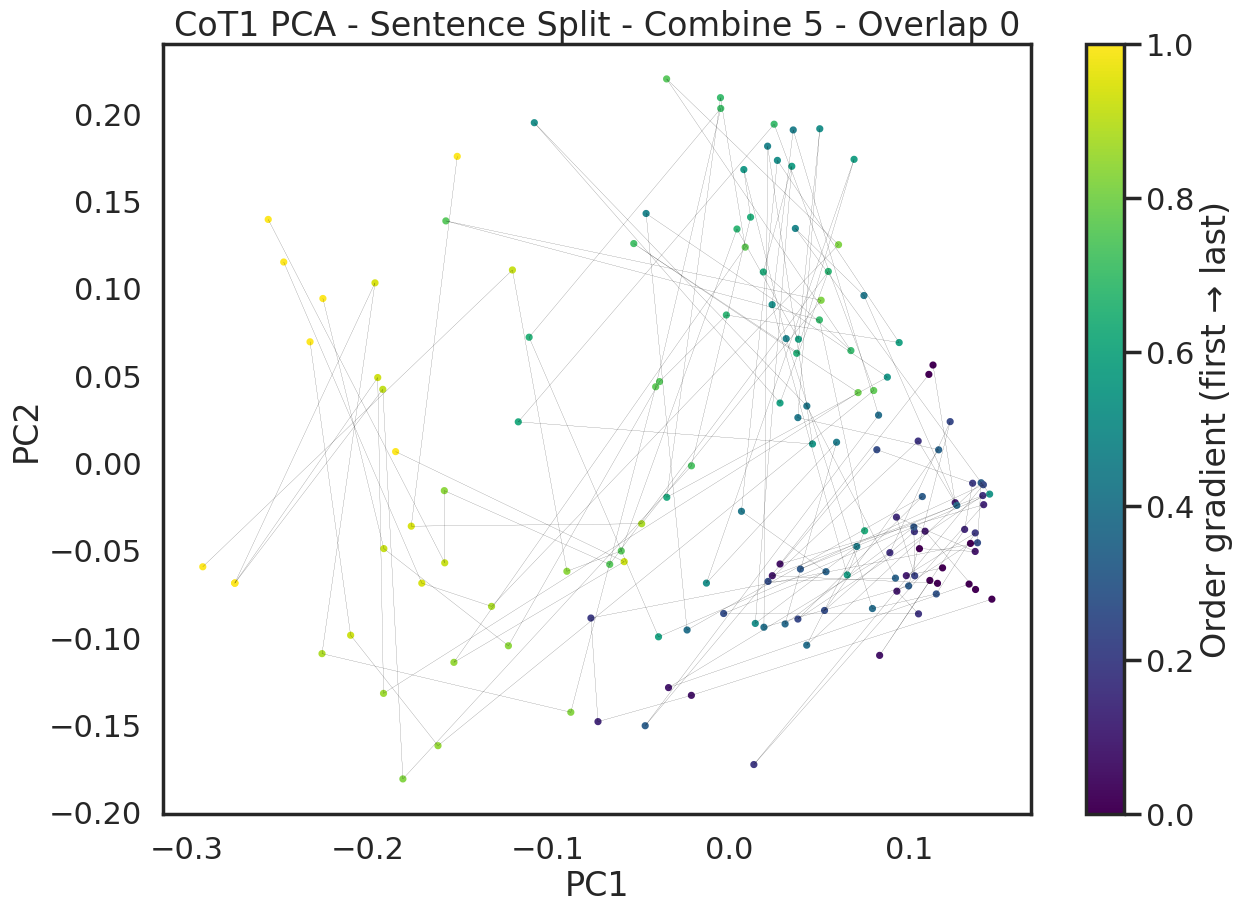

embeddings_cot1_splitSentence_comb5_over1.csv
(146, 768)
[12, 17, 13, 18, 17, 13, 13, 14, 14, 15]
[[129, 163, 193, 186, 231, 230, 159, 365, 192, 132, 149, 26], [187, 136, 118, 91, 219, 226, 207, 201, 137, 134, 383, 273, 132, 180, 212, 96, 163], [195, 198, 231, 196, 244, 235, 154, 299, 269, 229, 102, 140, 98], [167, 112, 150, 103, 210, 245, 189, 138, 179, 121, 94, 94, 167, 273, 119, 124, 179, 33], [108, 225, 223, 159, 152, 144, 184, 162, 130, 82, 137, 105, 99, 152, 223, 155, 139], [162, 197, 200, 200, 214, 256, 217, 332, 270, 155, 104, 135, 48], [198, 176, 201, 167, 139, 87, 154, 193, 367, 254, 137, 150, 147], [131, 120, 196, 166, 209, 263, 228, 201, 163, 128, 216, 155, 80, 132], [120, 132, 197, 171, 185, 83, 119, 193, 179, 130, 249, 150, 90, 101], [97, 137, 226, 215, 125, 184, 118, 109, 200, 159, 155, 215, 176, 146, 18]]
(146, 2)


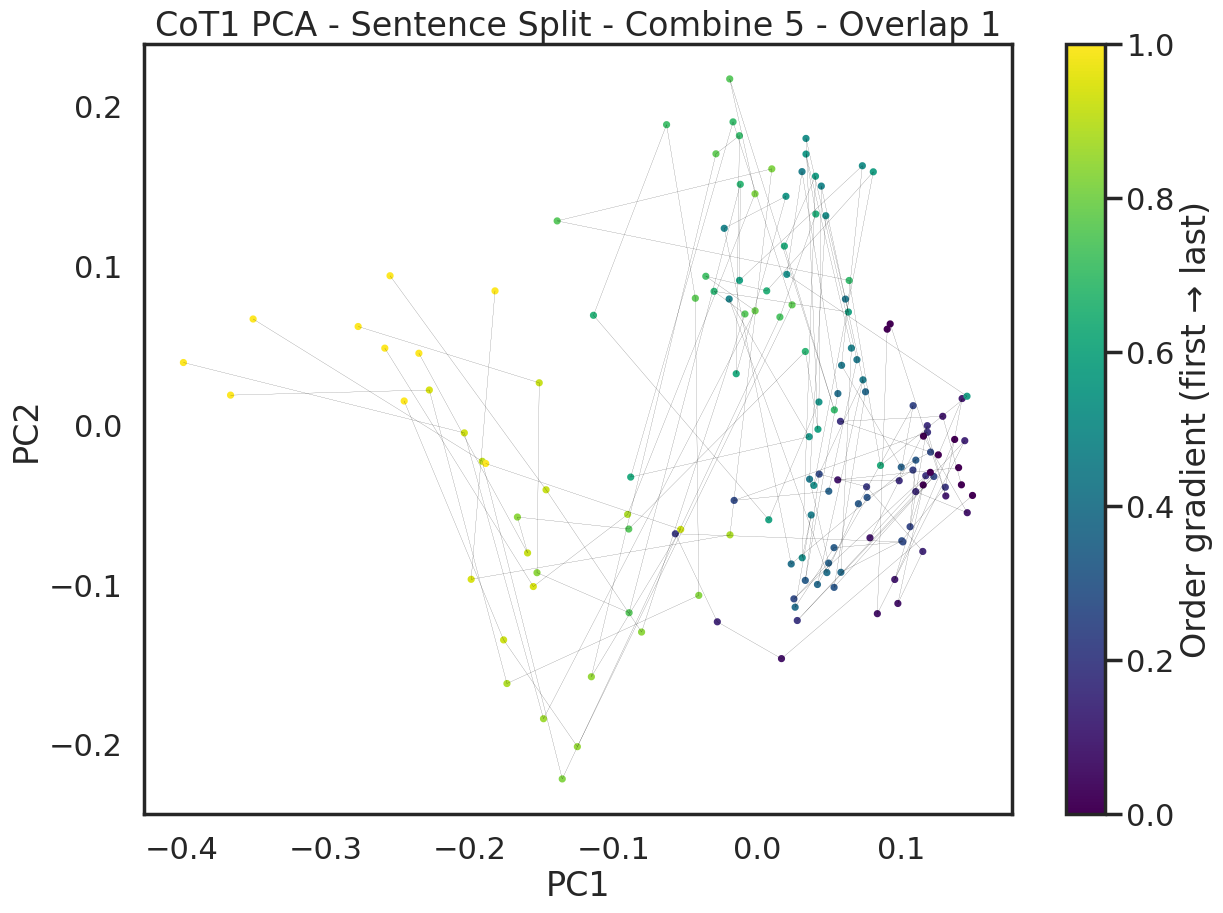

In [ ]:
# SPLIT BY SENTENCE
comb_value = 3
overlap_value = 1

for comb_value in [3, 5]:
  for overlap_value in [0, 1]:

    embedding_fname = f"embeddings_cot1_splitSentence_comb{comb_value}_over{overlap_value}.csv"

    n_segments_per_response = []
    embeddings = []
    n_tokens = []

    for file in output_files:
      # read in file
      with open(file, "r") as f:
        output = f.read()

      # split on period
      output_sentences = re.split(r'(?<=\S\.)\s', output)
      output_sentences_modified = segment(output_sentences, comb_value, overlap_value)
      n_tokens.append( count_tokens(output_sentences_modified) )

      # embeddings
      response_embeddings = get_embedding_intfloat(output_sentences_modified)

      n_segments_per_response.append(len(response_embeddings))
      embeddings.append(response_embeddings)

    np_arrays = [np.array(arr) for arr in embeddings]
    all_embeddings = np.vstack(np_arrays)

    print(embedding_fname)
    print(all_embeddings.shape)
    print(n_segments_per_response)
    print(n_tokens)

    np.savetxt(embedding_fname, all_embeddings, delimiter=",")
    # do the max token check -- lol what is this -_- jiu ming a


    png_fname = f"pca_cot1_splitSentence_comb{comb_value}_over{overlap_value}.png"

    # pca
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    print(embeddings_2d.shape)


    %matplotlib inline
    sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

    colors = []
    start_index = 0
    end_index = 0

    for i in range(0, len(output_files)):
      end_index = end_index + n_segments_per_response[i]

      colors = np.linspace(0, 1, n_segments_per_response[i])
      indices = np.arange(start_index, end_index)

      plt.plot(embeddings_2d[indices, 0], embeddings_2d[indices, 1], color="black", alpha=1, linewidth=0.1)
      plt.scatter(embeddings_2d[indices,0], embeddings_2d[indices,1], c=colors, s=10, cmap='viridis')

      start_index = end_index # for next iteration


    plt.colorbar(label='Order gradient (first → last)')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"CoT1 PCA - Sentence Split - Combine {comb_value} - Overlap {overlap_value}")
    plt.savefig(png_fname, dpi=300, bbox_inches='tight')
    plt.show()

# WORKFLOW FOR ** SPLIT

In [ ]:
output_files = sorted(glob.glob("cot2.1.*_output.txt"))
output_files

['cot2.1.0_output.txt',
 'cot2.1.1_output.txt',
 'cot2.1.2_output.txt',
 'cot2.1.3_output.txt',
 'cot2.1.4_output.txt',
 'cot2.1.5_output.txt',
 'cot2.1.6_output.txt',
 'cot2.1.7_output.txt',
 'cot2.1.8_output.txt',
 'cot2.1.9_output.txt']

embeddings_cot1_splitAA_comb3_over0.csv
(141, 768)
[14, 16, 12, 15, 17, 16, 12, 17, 12, 10]
[[36, 77, 112, 114, 168, 161, 116, 40, 207, 123, 123, 140, 160, 102], [239, 57, 49, 35, 75, 185, 184, 382, 167, 204, 209, 233, 180, 83, 142, 138], [300, 523, 89, 108, 149, 208, 146, 77, 257, 106, 124, 93], [169, 169, 160, 160, 191, 147, 72, 157, 104, 157, 123, 141, 209, 124, 133], [68, 93, 33, 116, 136, 249, 67, 135, 106, 135, 223, 169, 36, 218, 79, 159, 1], [38, 110, 106, 125, 176, 226, 95, 58, 192, 169, 159, 149, 113, 108, 132, 1], [233, 264, 257, 188, 159, 151, 131, 28, 196, 77, 86, 132], [41, 70, 107, 98, 154, 232, 69, 138, 65, 121, 119, 168, 118, 179, 104, 82, 89], [251, 177, 172, 193, 98, 156, 126, 146, 168, 93, 108, 75], [101, 266, 484, 127, 155, 359, 29, 171, 213, 1]]
(141, 2)


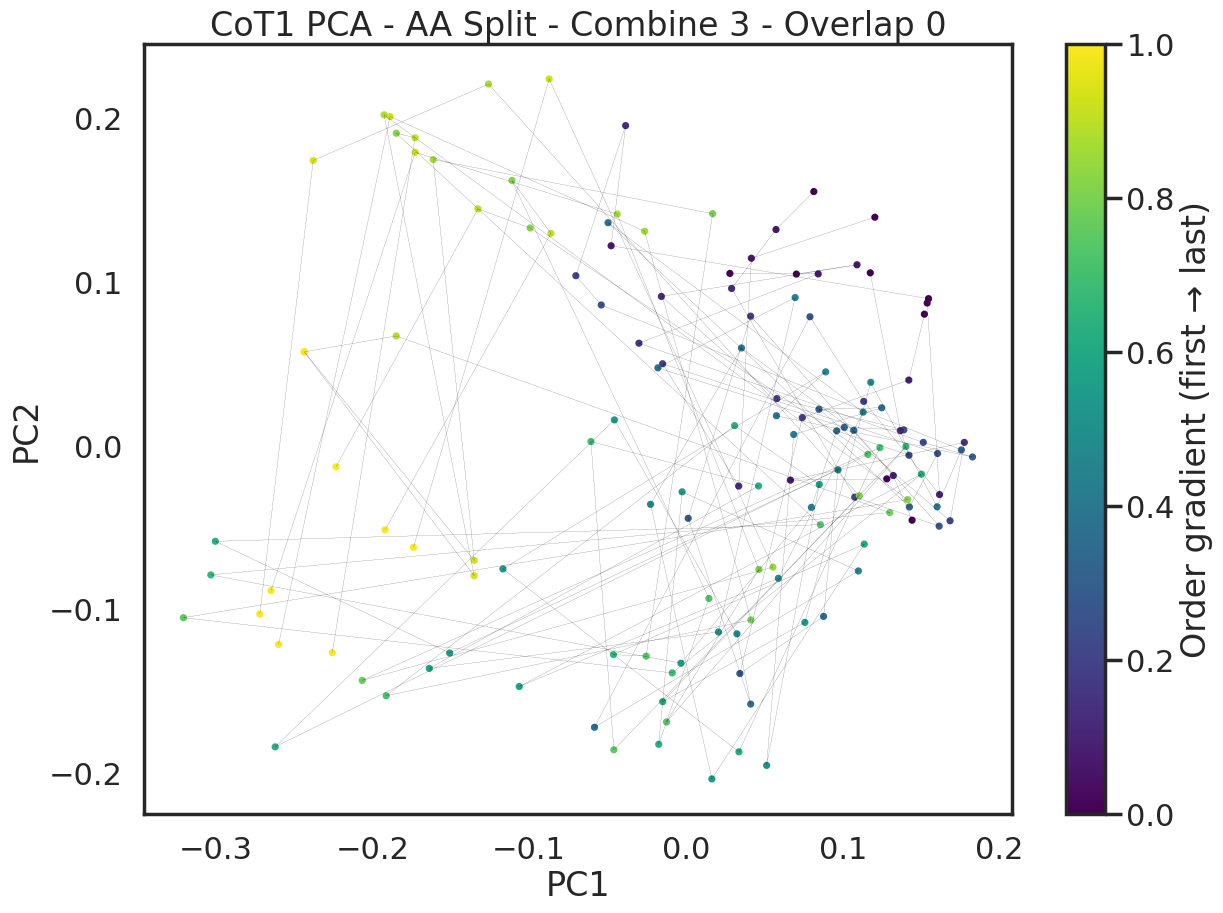

embeddings_cot1_splitAA_comb3_over1.csv
(141, 768)
[14, 16, 12, 15, 17, 16, 12, 17, 12, 10]
[[36, 89, 121, 167, 192, 197, 149, 77, 217, 238, 163, 187, 272, 204], [239, 169, 59, 57, 83, 196, 195, 395, 299, 260, 299, 316, 248, 235, 150, 155], [300, 687, 316, 137, 158, 263, 219, 125, 263, 187, 182, 113], [169, 303, 171, 171, 204, 163, 140, 165, 178, 203, 167, 170, 327, 132, 144], [68, 147, 115, 120, 235, 277, 185, 144, 146, 204, 233, 244, 90, 232, 117, 191, 120], [38, 124, 115, 175, 221, 281, 171, 102, 201, 251, 217, 204, 234, 117, 155, 102], [233, 383, 366, 264, 257, 171, 180, 75, 202, 116, 113, 142], [41, 87, 116, 148, 227, 323, 263, 145, 101, 166, 142, 230, 171, 189, 151, 123, 101], [251, 304, 284, 300, 151, 205, 165, 183, 189, 148, 154, 96], [101, 353, 659, 139, 206, 467, 277, 178, 238, 67]]
(141, 2)


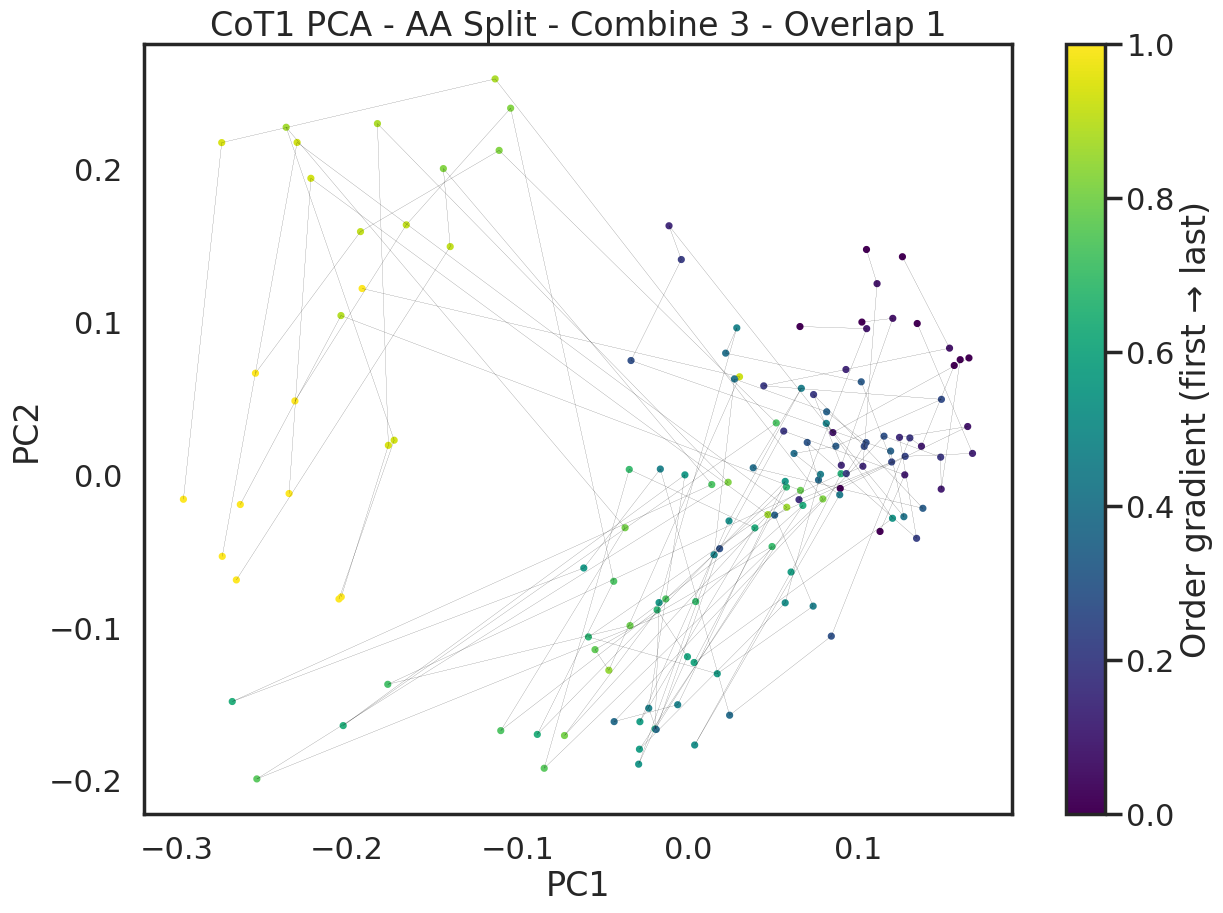

embeddings_cot1_splitAA_comb5_over0.csv
(86, 768)
[9, 10, 8, 9, 10, 10, 7, 10, 7, 6]
[[103, 132, 270, 239, 133, 273, 150, 283, 91], [285, 68, 100, 355, 495, 270, 373, 283, 189, 138], [595, 373, 199, 305, 281, 206, 216, 1], [326, 287, 234, 210, 208, 217, 145, 389, 194], [78, 125, 241, 306, 172, 212, 337, 230, 156, 159], [138, 126, 289, 276, 169, 293, 186, 290, 183, 1], [387, 446, 266, 234, 188, 159, 217], [101, 129, 238, 293, 154, 176, 233, 177, 276, 170], [315, 340, 234, 244, 189, 254, 182], [191, 665, 275, 380, 311, 80]]
(86, 2)


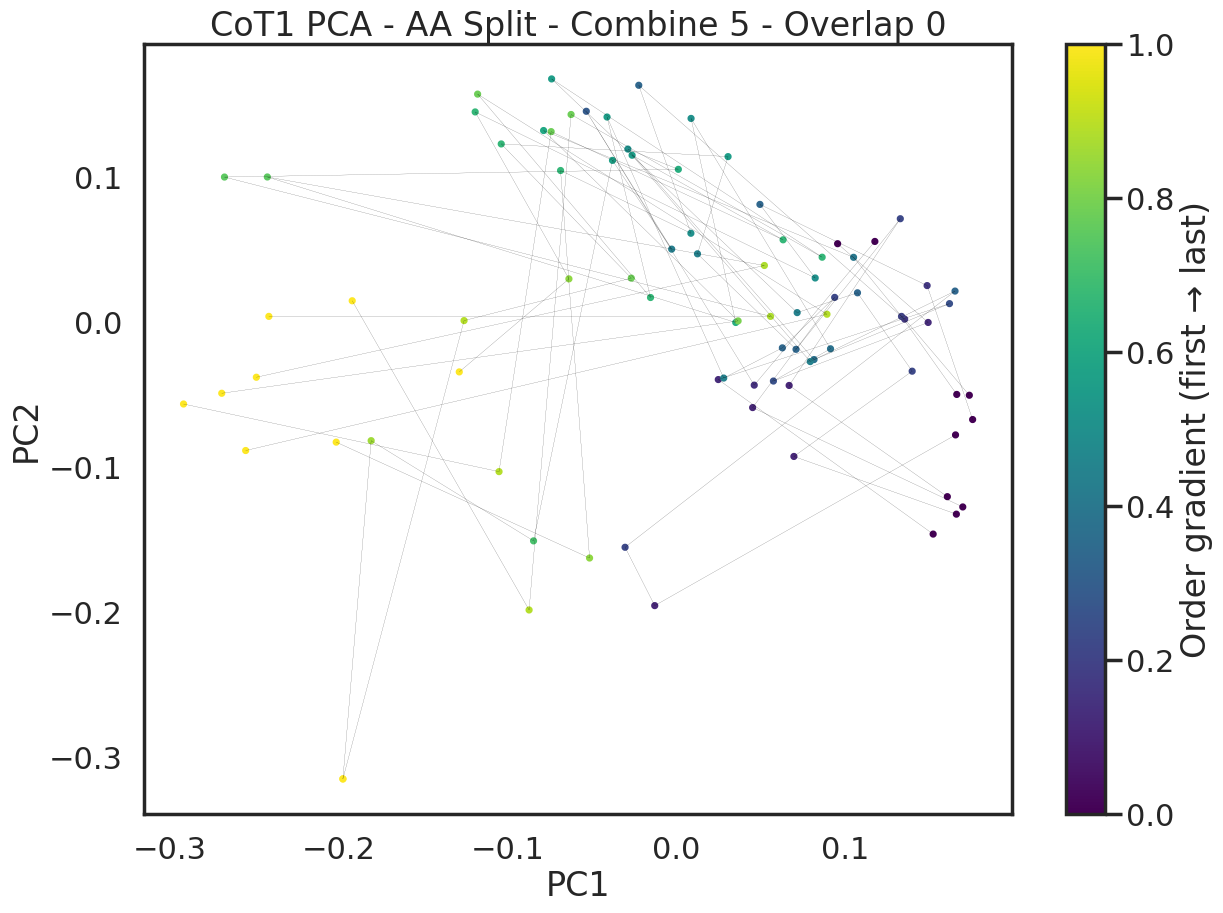

embeddings_cot1_splitAA_comb5_over1.csv
(86, 768)
[9, 10, 8, 9, 10, 10, 7, 10, 7, 6]
[[103, 167, 281, 275, 204, 329, 190, 289, 102], [285, 105, 109, 366, 533, 370, 463, 393, 224, 155], [595, 540, 256, 360, 316, 362, 274, 82], [326, 300, 350, 226, 222, 260, 189, 401, 256], [78, 129, 251, 334, 184, 240, 347, 283, 296, 191], [138, 160, 300, 331, 212, 360, 244, 296, 239, 102], [387, 587, 346, 254, 229, 272, 244], [101, 165, 251, 384, 170, 185, 256, 228, 282, 211], [315, 348, 290, 293, 235, 260, 228], [191, 674, 281, 488, 318, 213]]
(86, 2)


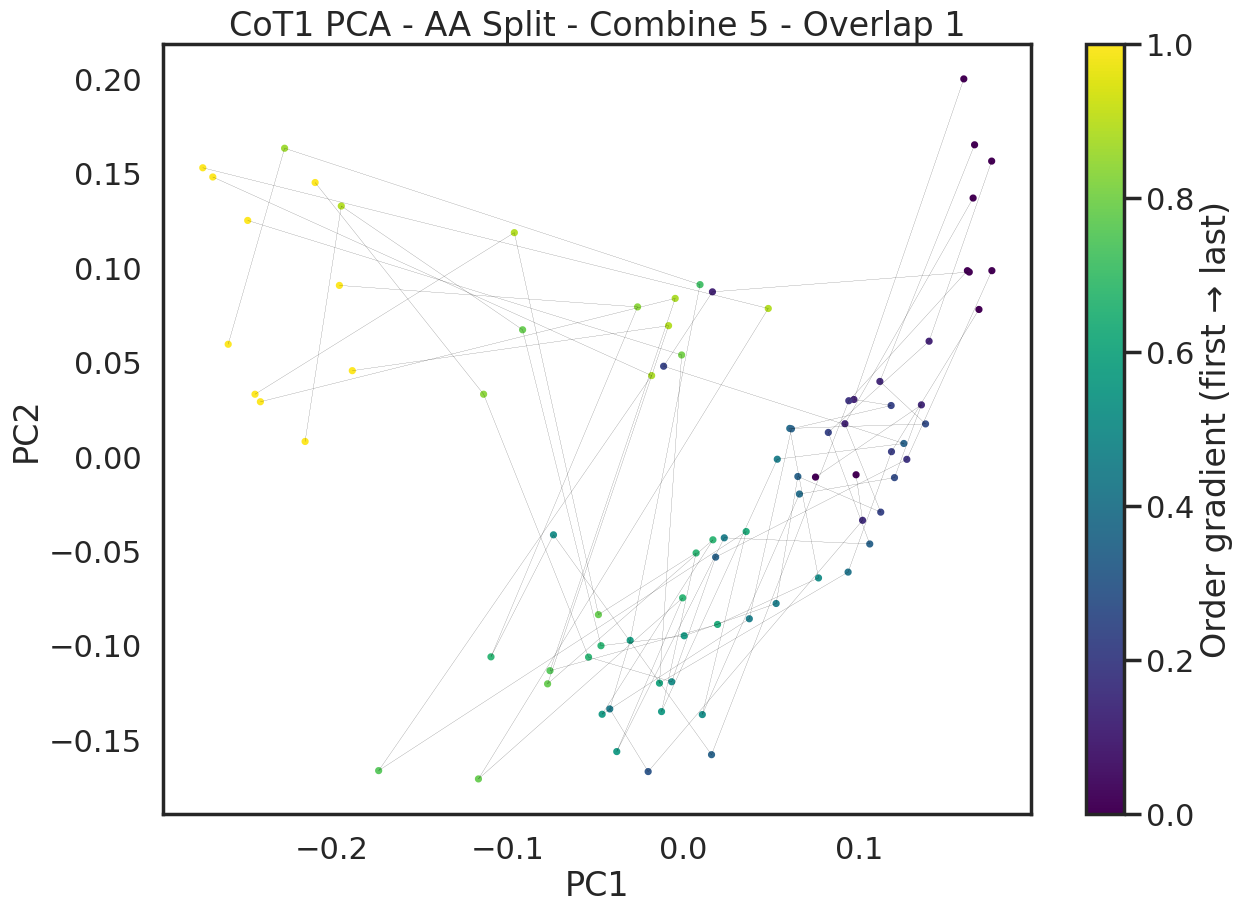

In [ ]:
# WORKFLOW FOR SPLIT ON **
for comb_value in [3, 5]:
  for overlap_value in [0, 1]:

    embedding_fname = f"embeddings_cot1_splitAA_comb{comb_value}_over{overlap_value}.csv"

    embeddings = []
    n_tokens = []
    n_segments_per_response = []
    for file in output_files:
      with open(file, "r") as f:
        output = f.read()

      output_split = split_combine_doubleA(output, "**")
      output_sentences_modified = segment(output_split, comb_value, overlap_value)
      n_tokens.append( count_tokens(output_sentences_modified) )

      # embeddings
      response_embeddings = get_embedding_intfloat(output_sentences_modified)

      n_segments_per_response.append(len(response_embeddings))
      embeddings.append(response_embeddings)

    np_arrays = [np.array(arr) for arr in embeddings]
    all_embeddings = np.vstack(np_arrays)
    print(embedding_fname)
    print(all_embeddings.shape)
    print(n_segments_per_response)
    print(n_tokens)

    np.savetxt(embedding_fname, all_embeddings, delimiter=",")

    png_fname = f"pca_cot1_splitAA_comb{comb_value}_over{overlap_value}.png"

    # pca
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)
    print(embeddings_2d.shape)


    %matplotlib inline
    sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

    colors = []
    start_index = 0
    end_index = 0

    for i in range(0, len(output_files)):
      end_index = end_index + n_segments_per_response[i]

      colors = np.linspace(0, 1, n_segments_per_response[i])
      indices = np.arange(start_index, end_index)

      plt.plot(embeddings_2d[indices, 0], embeddings_2d[indices, 1], color="black", alpha=1, linewidth=0.1)
      plt.scatter(embeddings_2d[indices,0], embeddings_2d[indices,1], c=colors, s=10, cmap='viridis')

      start_index = end_index # for next iteration


    plt.colorbar(label='Order gradient (first → last)')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"CoT1 PCA - AA Split - Combine {comb_value} - Overlap {overlap_value}")
    plt.savefig(png_fname, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
n_segments_per_response

[18, 15, 35, 24, 19, 25, 52, 23, 19, 20]

In [ ]:
print(embedding_fname)
print(png_fname)

embeddings_cot2_splitAA_comb3_over1.csv
pca_cot2_splitAA_comb3_over1.png


# umaps for both CoTs

In [ ]:
embedding_files = sorted(glob.glob('embeddings_cot*_splitAA*.csv'))
embedding_files

['embeddings_cot1_splitAA_comb5_over1.csv',
 'embeddings_cot2_splitAA_comb5_over1.csv',
 'embeddings_cot3.1_splitAA_comb2_over1.csv']

In [ ]:
embeddings = []
for file in embedding_files:
  embeddings.append(np.loadtxt(file, delimiter=','))

In [ ]:
# in order of cot, same order as embeddings
segs = np.array(
    [[9, 10, 8, 9, 10, 10, 7, 10, 7, 6],
     [11, 10, 21, 15, 12, 16, 31, 14, 12, 12],
     [6, 9, 12, 5, 12, 8, 2, 10, 2, 6]]
)

# segs = segs - 1

In [ ]:
all_embeddings_combined = np.vstack(embeddings)
all_embeddings_combined.shape

(312, 768)

In [ ]:
# pca
pca = PCA(n_components=2)
embeddings_2d_combined = pca.fit_transform(all_embeddings_combined)
print(embeddings_2d_combined.shape)

(312, 2)


In [ ]:
[sum(i) for i in segs]

[np.int64(86), np.int64(154), np.int64(72)]

In [ ]:
pca_split = []
pca_split.append(embeddings_2d_combined[0:86])
pca_split.append(embeddings_2d_combined[86:154+86])
pca_split.append(embeddings_2d_combined[154+86:])


# EX: output: [np.int64(86), np.int64(154), np.int64(50)]
# pca_split.append(embeddings_2d_combined[0:86])
# pca_split.append(embeddings_2d_combined[86:154+86])
# pca_split.append(embeddings_2d_combined[154+86:])

In [ ]:
[len(i) for i in pca_split]

[86, 154, 72]

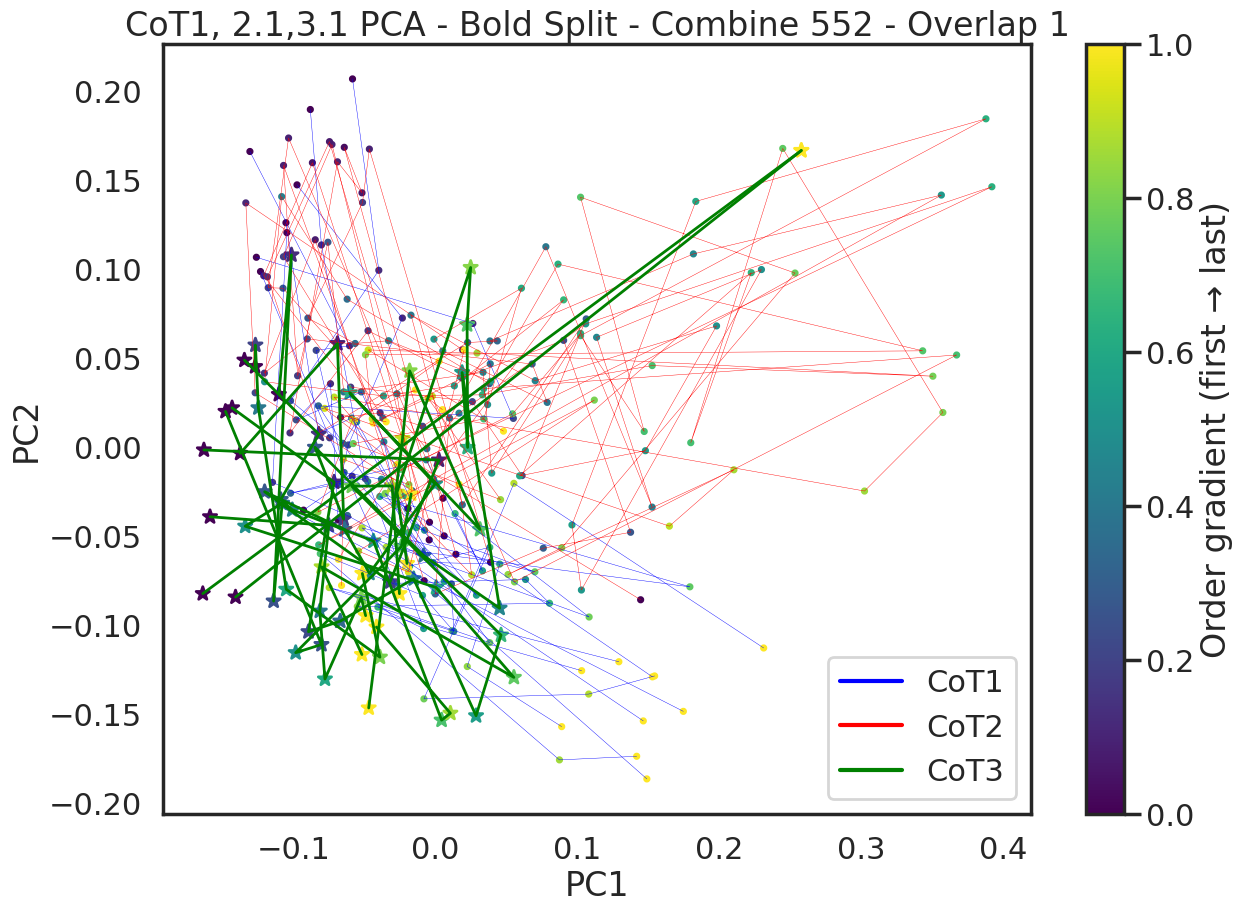

In [ ]:
# umaps for 2 cots

%matplotlib inline
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

colors = []

for j in range(0, len(embeddings)):
  start_index = 0
  end_index = 0
  lw = 0.3
  ptsize = 10
  marker = 'o'

  if j == 0:
    cot_color = 'blue'
  if j == 1:
    cot_color = 'red'
  if j == 2:
    cot_color = 'green'
    lw = 2
    ptsize = 100
    marker = '*'

  embeddings_2d = pca_split[j]
  n_segments_per_response = segs[j]

  for i in range(0, len(n_segments_per_response)):
    end_index = end_index + n_segments_per_response[i]

    colors = np.linspace(0, 1, n_segments_per_response[i])
    indices = np.arange(start_index, end_index)

    plt.plot(embeddings_2d[indices, 0], embeddings_2d[indices, 1], color=cot_color, alpha=1, linewidth=lw)
    plt.scatter(embeddings_2d[indices,0], embeddings_2d[indices,1], c=colors, s=ptsize, marker=marker, cmap='viridis')

    start_index = end_index # for next iteration

blue_line = mlines.Line2D([], [], color='blue', label='CoT1')
red_line = mlines.Line2D([], [], color='red', label='CoT2')
green_line = mlines.Line2D([], [], color='green', label='CoT3')
plt.legend(handles=[blue_line, red_line, green_line])

plt.colorbar(label='Order gradient (first → last)')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("CoT1, 2.1,3.1 PCA - Bold Split - Combine 552 - Overlap 1")
plt.show()

# COSINE SIMILARITY BETWEEN RESPONSES

In [ ]:
output_files = sorted(glob.glob("cot*_output.txt"))
output_files

['cot1.0_output.txt',
 'cot1.1_output.txt',
 'cot1.2_output.txt',
 'cot1.3_output.txt',
 'cot1.4_output.txt',
 'cot1.5_output.txt',
 'cot1.6_output.txt',
 'cot1.7_output.txt',
 'cot1.8_output.txt',
 'cot1.9_output.txt',
 'cot2.1.0_output.txt',
 'cot2.1.1_output.txt',
 'cot2.1.2_output.txt',
 'cot2.1.3_output.txt',
 'cot2.1.4_output.txt',
 'cot2.1.5_output.txt',
 'cot2.1.6_output.txt',
 'cot2.1.7_output.txt',
 'cot2.1.8_output.txt',
 'cot2.1.9_output.txt']

In [ ]:
all_doc_embs = []
for file in output_files:
  with open(file, 'r') as f:
    output = f.read()

  all_doc_embs.append( get_embedding_intfloat(output) )

all_doc_embs = np.vstack(np.array(all_doc_embs))
all_doc_embs.shape

(20, 768)

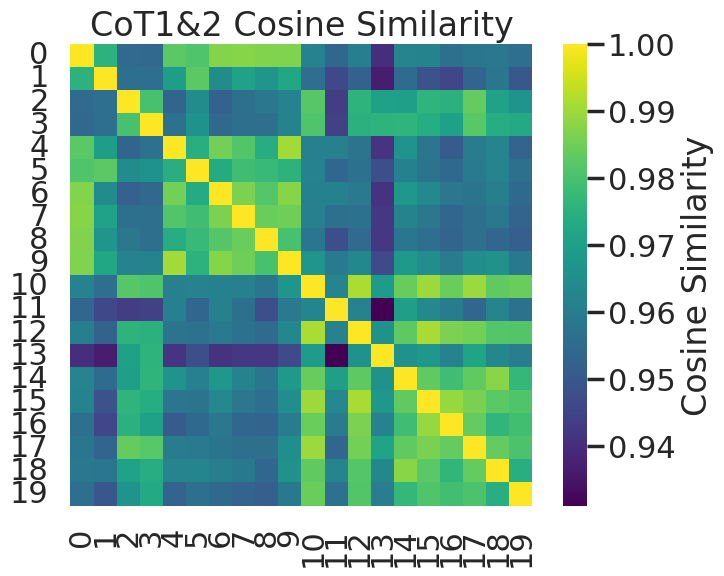

In [ ]:

# 1️⃣ Compute pairwise cosine similarity
sim_matrix = cosine_similarity(all_doc_embs)

# 2️⃣ Plot as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix,
            cmap="viridis",
            square=True,
            cbar_kws={"label": "Cosine Similarity"},
            xticklabels=np.arange(0, 20),
            yticklabels=np.arange(0, 20))

plt.title("CoT1&2 Cosine Similarity")
plt.show()